# Read Data

## Read Long Format data

In [1]:
import pandas as pd
df = pd.read_pickle('output/critical_15min_long_format.pickle')

# string representation of time
df['interval_timestr'] = df['interval_time'].astype(str)

# calculate kgCO2eq 
df['kgCO2eq'] = df['charge'] * df['kgCO2eq/kWh']


## Read and prepare Survey Data

In [2]:
# read data
survey_df = pd.read_csv('input/freq_survey.csv')
                        
# calculate a weight for the distribution
survey_df['Weight'] = survey_df['Freq'] / survey_df['Freq'].sum() 
                        
# transorm times to datetimes
survey_df['Time start'] = pd.to_datetime(survey_df['Time start']) 
survey_df['Time End'] = pd.to_datetime(survey_df['Time End']) 

# create a distribution with 15 minutes intervals
survey_df = pd.DataFrame([(interval, row['Weight']) 
                          for _,row in survey_df.iterrows() 
                          for interval in pd.date_range(row['Time start'], row['Time End'], freq='15min', closed='left')], 
                         columns=['interval_time', 'weight'])

# string representation of time
survey_df['interval_timestr'] = survey_df['interval_time'].dt.time.astype(str)

# represent the distribution as a series
survey_dist = survey_df.set_index('interval_timestr')['weight']
                        
# re-weight the weights after the 15 minutes time expansion
survey_dist= survey_dist / survey_dist.sum()

# Calculate the projections

In [3]:
kilowatts = df[df.mailday & df.mailed].charge.sum()
print(kilowatts)

# extract a time series of the co2 emisions
co2 = df.drop_duplicates(['interval', '17h_day', 'mailday', 'interval_timestr', 'kgCO2eq/kWh']).copy()

# split them in the ones for maildays, and the one for non mail days
co2_md = co2.loc[co2.mailday,:].groupby(['interval_timestr'])['kgCO2eq/kWh'].mean()
co2_nmd = co2.loc[~co2.mailday,:].groupby(['interval_timestr'])['kgCO2eq/kWh'].mean()

# a dummy uniform distribution for the minimum values
co2_md_min = co2_md.copy()
co2_md_min = co2_md.min()

# a dummy uniform distribution for the maximum values
co2_md_max = co2_md.copy()
co2_md_max = co2_md.max()

# a dummy uniform distribution for the mean 
co2_md_mean = co2_md.copy()
co2_md_mean = co2_md.mean()

# mean kgCO2eq/kWh for critical times
mean_crit = co2[co2.mailday & ((pd.to_timedelta(co2['interval_time'].astype(str)) >=  pd.Timedelta('11:00:00')) & 
    (pd.to_timedelta(co2['interval_time'].astype(str)) <  pd.Timedelta('15:00:00')))]['kgCO2eq/kWh'].mean()

# mean kgCO2eq/kWh for critical times
mean_noncrit = co2[co2.mailday & ~((pd.to_timedelta(co2['interval_time'].astype(str)) >=  pd.Timedelta('11:00:00')) & 
    (pd.to_timedelta(co2['interval_time'].astype(str)) <  pd.Timedelta('15:00:00')))]['kgCO2eq/kWh'].mean()

1136.428325141204


In [4]:
# calculate the kw distribution for maildays and non maildays
kw_md_dist = df.loc[df.mailday & df.mailed, :].groupby(['interval_timestr'])['charge'].sum()
kw_nmd_dist = df.loc[~df.mailday,:].groupby(['interval_timestr'])['charge'].sum()

# normalize (or weight theme)
kw_md_dist = kw_md_dist / kw_md_dist.sum()
kw_nmd_dist = kw_nmd_dist / kw_nmd_dist.sum()

# create the projections that will be bars in the plot
dict_bars = {
'Real emissions': df.loc[df.mailday & df.mailed,:]['kgCO2eq'].sum(),
'Projection using charging\ndistribution from\nno mail days': ((kw_nmd_dist*kilowatts) * co2_nmd).sum(),
#'proj2mean_crit': (kilowatts * mean_crit).sum(),
#'proj2mean_noncrit': (kilowatts * mean_noncrit).sum(),
'Projection using charging\ndistribution based\non survey-data': ((survey_dist*kilowatts) * co2_md).sum(),
}

# create the projections that will be lines in the plot
dict_lines = {
'min': ((kw_md_dist*kilowatts) * co2_md_min).sum(),
'max': ((kw_md_dist*kilowatts) * co2_md_max).sum(),
'mean': ((kw_md_dist*kilowatts) * co2_md_mean).sum(),
}
dict_bars


{'Real emissions': 81.96495600460017,
 'Projection using charging\ndistribution from\nno mail days': 163.55511467396263,
 'Projection using charging\ndistribution based\non survey-data': 163.1567790203512}

# Plot the projections

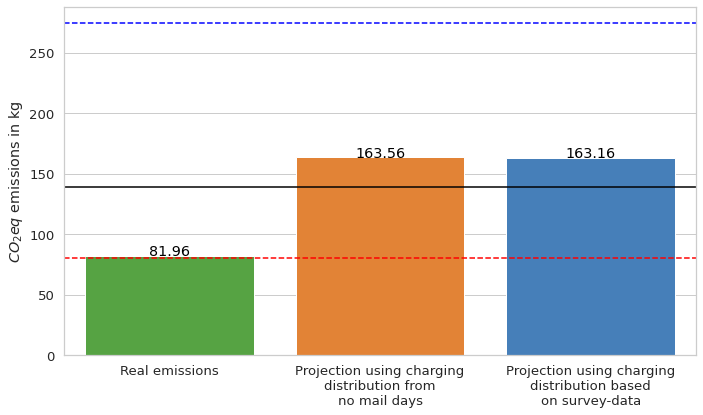

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="whitegrid", font_scale=1.2)

fig, ax= plt.subplots(figsize=(10,6))

dfplot = pd.Series(dict_bars).to_frame().reset_index()

sns.set_palette([ (0.3, 0.7, 0.2), (1.0, 0.5, 0.1), (0.2, 0.5, 0.8)])
g = sns.barplot(data=dfplot, x="index", y=0)

g.axes.axhline(dict_lines['min'], ls='--', c='red')
g.axes.axhline(dict_lines['max'], ls='--', c='blue')
g.axes.axhline(dict_lines['mean'], ls='-', c='black')

for index, row in dfplot.iterrows():
    g.text(row.name,row[0], round(row[0],2), color='black', ha="center")

g.axes.set_xlabel('')
g.axes.set_ylabel('$CO_2eq$ emissions in kg')

plt.tight_layout()